In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import itertools
from PIL import Image
from scipy.stats import logistic
import math

import csv

x_list=[]
y_list=[]
A_list=[]

# opening the CSV file
with open('.\\finale\\data1.csv', mode ='r') as file:
   
    # reading the CSV file
    csvFile = csv.reader(file)
 
    # displaying the contents of the CSV file
    for lines in csvFile:
        x_list.append(float(lines[0]))
        y_list.append(float(lines[1]))
        A_list.append(float(lines[2]))

In [2]:
plt.rcParams['figure.figsize'] = (20,12)


In [3]:

def moving_avg(half_width,input_dat):
    start_index=0
    end_index=0
    avg_dat=np.zeros(2048-half_width)
    for i in input_dat:
        ycoor=i[1]

        start=max(0,int(ycoor)-half_width+1)
        end=min(2048-half_width,int(ycoor)+half_width)

        avg_dat[start:end]=avg_dat[start:end]+i[2]
    return avg_dat

def cutting(cut_num):
    cut_thick=int(2048/cut_num)
    index=0
    l=len(x_list)
    A_dot=[]
    B_dot=[]
    cut_point=[0]
    for n in range(cut_num):
        for i in range(index,l):
            if(x_list[i]>(n+1)*cut_thick):
                index=i
                cut_point.append(index)
                break
        dat=np.transpose([x_list[cut_point[-2]:cut_point[-1]],y_list[cut_point[-2]:cut_point[-1]],A_list[cut_point[-2]:cut_point[-1]]])
        dat = dat[dat[:,1].argsort()]
        ls=moving_avg(10,dat)[::-1]
        #plt.plot(ls)
        #dot.append([int(n*cut_thick+cut_thick/2),np.argmax(ls)])
        """
        for i in range(len(ls)):
            if(ls[i]-ls[i-50]>160000/cut_num):
                dot.append([int(n*cut_thick+cut_thick/2),2048-25-i])
                break
        break
        
        """
        tmp=0
        sec_tmp=0
        tmp_index=0
        sec_tmp_index=0
        
        max_width=100
        for i in range(len(ls)):
            start=max(0,i-max_width)
            end=min(2048,i+max_width)
            if(ls[i]==max(ls[start:end])):
                if(ls[i]>tmp):
                    sec_tmp=tmp
                    sec_tmp_index=tmp_index
                    tmp=ls[i]
                    tmp_index=i
                elif(ls[i]>sec_tmp):
                    sec_tmp=ls[i]
                    sec_tmp_index=i
        A_dot.append([int(n*cut_thick+cut_thick/2),2048-10-min(sec_tmp_index,tmp_index)])
        B_dot.append([int(n*cut_thick+cut_thick/2),2048-10-max(sec_tmp_index,tmp_index)])


    return [A_dot,B_dot]


[[  32 1465]
 [  96 1460]
 [ 160 1450]
 [ 224 1446]
 [ 288 1438]
 [ 352 1435]
 [ 416 1433]
 [ 480 1429]
 [ 544 1426]
 [ 608 1425]
 [ 672 1426]
 [ 736 1422]
 [ 800 1423]
 [ 864 1418]
 [ 928 1423]
 [ 992 1421]
 [1056 1421]
 [1120 1424]
 [1184 1428]
 [1248 1433]
 [1312 1435]
 [1376 1441]
 [1440 1442]
 [1504 1449]
 [1568 1457]
 [1632 1464]
 [1696 1466]
 [1760 1476]
 [1824 1482]
 [1888 1494]
 [1952 1506]
 [2016 1506]]
[[  32 1324]
 [  96 1314]
 [ 160 1312]
 [ 224 1301]
 [ 288 1297]
 [ 352 1291]
 [ 416 1286]
 [ 480 1286]
 [ 544 1287]
 [ 608 1281]
 [ 672 1281]
 [ 736 1281]
 [ 800 1278]
 [ 864 1279]
 [ 928 1284]
 [ 992 1283]
 [1056 1281]
 [1120 1282]
 [1184 1282]
 [1248 1290]
 [1312 1295]
 [1376 1293]
 [1440 1305]
 [1504 1303]
 [1568 1313]
 [1632 1322]
 [1696 1324]
 [1760 1328]
 [1824 1341]
 [1888 1347]
 [1952 1356]
 [2016 1356]]


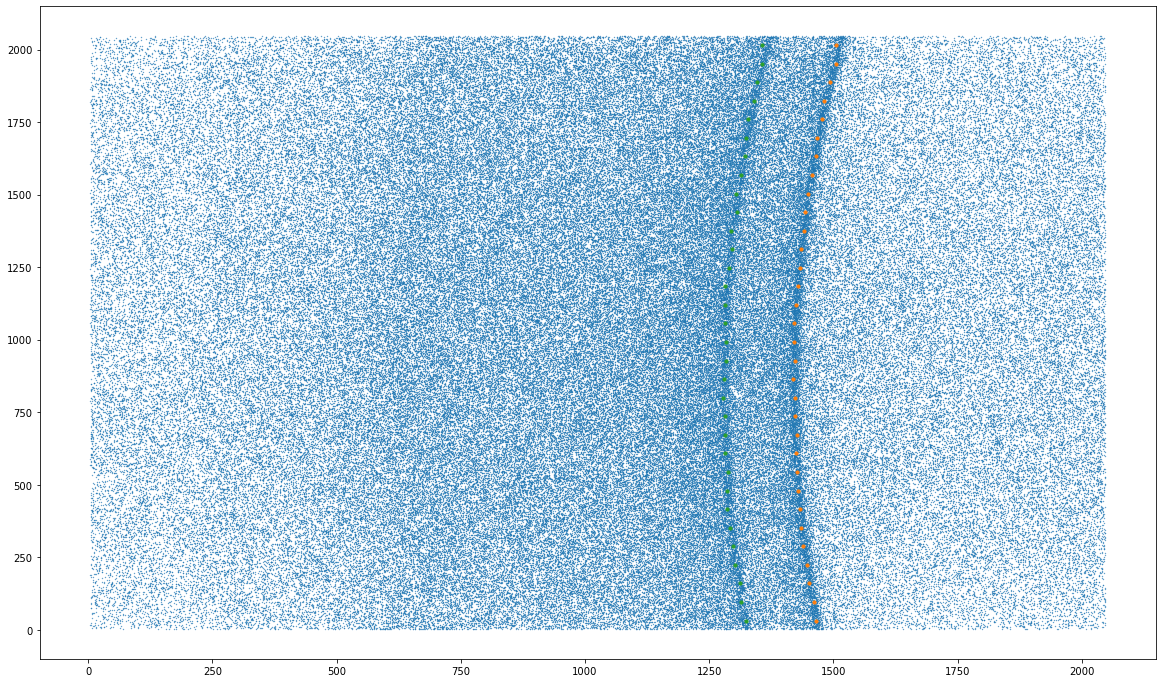

In [4]:
cut_num=32

data=np.transpose([x_list,y_list,A_list])
data=data[data[:,0].argsort()]
x_list,y_list,A_list=np.transpose(data)

A_points, B_points=cutting(cut_num)
A_points=np.transpose(A_points)
B_points=np.transpose(B_points)


print(np.transpose(A_points))
print(np.transpose(B_points))
plt.scatter(y_list,x_list,s=0.1)
plt.scatter(A_points[1],A_points[0],s=10)
plt.scatter(B_points[1],B_points[0],s=10)


In [30]:
err_range=40

class geometry_fitting:
    
    def __init__(self,pz,alpha,theta,x0,y0):
        self.pz=pz
        self.alpha=alpha
        self.theta=theta
        self.x0=x0
        self.y0=y0
        
    def new_value(self,pz,alpha,theta,x0,y0):
        self.pz=pz
        self.alpha=alpha
        self.theta=theta
        self.x0=x0
        self.y0=y0
    
    def value(self,x,y):
        x=x-self.x0
        y=y-self.y0
        return np.sqrt(x**2+y**2+self.pz**2)*np.sin(self.theta)-y*np.sin(self.alpha)-self.pz*np.cos(self.alpha)
    
    def error(self,point_list):
        err=0
        for point in point_list:
            x=point[0]-self.x0
            y=point[1]-self.y0
            err=err+(np.sqrt(x**2+y**2+self.pz**2)*np.sin(self.theta)-y*np.sin(self.alpha)-self.pz*np.cos(self.alpha))**2
        return err
    
    def heatmap(self):
        x=range(2048)
        y=range(2048)
        z=np.zeros([2048,2048])
        for i in x:
            for j in y:
                z[i,j]=self.value(i,j)
        
        plt.contourf(x,y,z,cmap=plt.get_cmap('hot'))
        plt.colorbar()
        
    def plot(self):
        x=range(2048)
        y=range(2048)
        z=np.zeros([2048,2048])
        for i in x:
            for j in y:
                if(np.abs(self.value(i,j))>err_range):
                    z[i,j]=1
                else:
                    z[i,j]=0
        
        plt.contourf(x,y,z,cmap=plt.get_cmap('hot'))
        plt.colorbar()

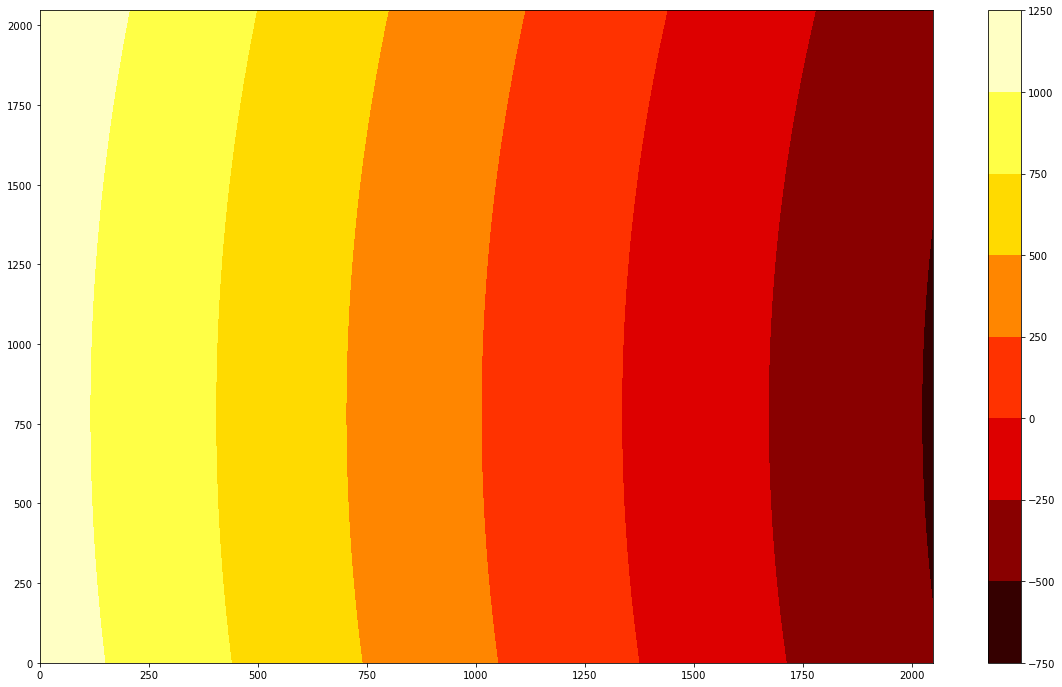

In [31]:
ft_trial=geometry_fitting(6.45836450e+03,9.84928205e-01,0.7,7.80871045e+02,5.93963222e+02)
ft_trial.heatmap()

In [28]:
ft_trial=geometry_fitting(6000,1,0.7,796,600)
print(ft_trial.error(A_points))

1194501.3937500862


In [ ]:

def gradient_descent_fitting(cut,ft=trial_A,output='verbose'):
    points=np.transpose(cut)
    for i in range(100):

        a=ft.a
        b=ft.b
        c=ft.c
        d=ft.d
        x0=ft.x0
        y0=ft.y0
        if(output=='verbose'):
            print(i,'para',[a,b,c,d,x0,y0])
        err=ft.error(points)
        if(output=='verbose'):
            print(err)
        ft.new_value(a+ft_d_a,b,c,d,x0,y0)
        err_a=ft.error(points)-err
        ft.new_value(a,b+ft_d_b,c,d,x0,y0)
        err_b=ft.error(points)-err
        ft.new_value(a,b,c+ft_d_c,d,x0,y0)
        err_c=ft.error(points)-err
        ft.new_value(a,b,c,d+ft_d_d,x0,y0)
        err_d=ft.error(points)-err
        ft.new_value(a,b,c,d,x0+ft_d_x0,y0)
        err_x0=ft.error(points)-err
        ft.new_value(a,b,c,d,x0,y0+ft_d_y0)
        err_y0=ft.error(points)-err
        
        if(output=='verbose'):
            print('err',[err_a,err_b,err_c,err_d,err_x0,err_y0])
        
        a=a-err_a*ft_descent_factor*ft_d_a
        b=b-err_b*ft_descent_factor*ft_d_b
        c=c-err_c*ft_descent_factor*ft_d_c
        d=d-err_d*ft_descent_factor*ft_d_d
        x0=x0-err_x0*ft_descent_factor*ft_d_x0
        y0=y0-err_y0*ft_descent_factor*ft_d_y0
        
        ft.new_value(a,b,c,d,x0,y0)
    
    print(a,b,c,d,x0,y0,err)
    return ft


ft_d_a=0.0001
ft_d_b=0.00001
ft_d_c=0.0001
ft_d_d=100
ft_d_x0=0.01
ft_d_y0=0.01
ft_descent_factor=0.00000003

#trial.plot()
#plt.scatter(cut[1],cut[0],s=10)
#plt.scatter(y_list,x_list,s=0.1)
#trial.conic_section(192,1443)
